# 📘 Proje Girişi: Enerji Verimliliği için Soft-Cell Koordinasyonu

Bu çalışma, **"Massive MIMO and Small Cells: Improving Energy Efficiency by Optimal Soft-Cell Coordination"** başlıklı makaleye dayanmaktadır. Hızla artan kullanıcı sayısı ve kalite beklentileri karşısında klasik makro hücre mimarisi yetersiz kalmaktadır. Bu nedenle, hücre yoğunluğunu artırarak enerji verimliliğini yükseltmek amacıyla iki temel yaklaşım ele alınmaktadır:

1. **Massive MIMO (Çok Antenli Baz İstasyonları)**: Büyük anten dizileri kullanılarak kullanıcıya doğru odaklanmış enerji aktarımı sağlanır.
2. **Small Cell Access Points (SCA)**: Kullanıcılara daha yakın, düşük güçlü ek verici noktaları eklenerek kapsama alanı küçültülür ve sinyal zayıflaması azaltılır.

Makale bu iki yaklaşımı birleştirerek, enerji tüketimini azaltırken kullanıcıların **Quality-of-Service (QoS)** ihtiyaçlarını karşılayan bir sistem önerir. Kullanıcılar, baz istasyonu (BS) ve küçük hücrelerden (SCA) aynı anda sinyal alabilir. Bu **non-coherent multiflow transmission (çok vericili, senkronizasyonsuz aktarım)** yaklaşımı, karmaşık koherens gerektirmeden çoklu vericiden hizmet almayı sağlar.

### 🎯 Amaç:
Toplam güç tüketimini (yayın gücü + devre güçleri) minimize etmek; bu sırada her kullanıcıya en az belirlenen bir QoS sağlamak.

### 🛠️ Kullanılan Yöntemler:
- **Optimizasyon Temelli Çözüm**: SINR eşikleri ve güç kısıtlamaları altında toplam gücü minimize eden konveks bir optimizasyon problemi çözülür.
- **CVX (MATLAB) / CVXPY (Python)**: Konveks optimizasyon problemi bu araçlarla çözülür.
- **Çoklu Senaryo Simülasyonları**: Farklı anten sayılarına, QoS seviyelerine ve SCA konfigürasyonlarına göre enerji tüketimi analiz edilir.
- **Alternatif Olarak Reinforcement Learning (RL)**


# Massive MIMO ve Small Cell'ler: RL Tabanlı Enerji Verimliliği Projesi

## 📘 Proje Tanımı
Bu notebook, ICT 2013 konferansında yayımlanan "Massive MIMO and Small Cells: Improving Energy Efficiency by Optimal Soft-Cell Coordination" başlıklı makalenin içeriğini anlatır ve MATLAB + CVX kullanılarak elde edilen sonuçları Python'da yeniden üretir. Sonraki aşamada, bu problemi takviyeli öğrenme (reinforcement learning) ile çözmenin potansiyeli incelenecektir.

## 🔧 Başlangıç ve Simülasyon Parametrelerinin Tanımlanması

Bu bölüm, makaledeki **Şekil 3**'ün yeniden üretimi için temel simülasyon parametrelerini tanımlar. Bu parametreler, makalenin **Bölüm IV – Numerical Evaluations** kısmında geçen LTE-benzeri sistemin yapısını yansıtır.

- **nbrOfRealizations**: Farklı kanal durumları altında ortalama sonuçları hesaplamak için kullanılacak kanal gerçekleştirim sayısıdır.
- **relaxPowerConstraintsIfNeeded**: Bazı kullanıcı yerleşimlerinin güç kısıtlamaları altında hizmet verilememesi durumunda, çözümün olanaklı kalması için güç sınırlarının gevşetilmesine izin verir.
- **nbrOfSubCarriers** ve **subcarrierBandwidth**: LTE sistemine benzer şekilde sistemin toplam alt taşıyıcı sayısı ve her birinin bant genişliğini belirler.
- **noiseFigure** ve **noiseFloordBm**: Alıcıdaki ek gürültü faktörünü (dB cinsinden) ve toplam gürültü taban seviyesini (dBm cinsinden) hesaplar.
- **Kt** ve **Kr**: Sistemdeki toplam verici (1 baz istasyonu + 4 küçük hücre erişim noktası) ve kullanıcı sayısını ifade eder.
- **QoSconstraints** ve **SINRconstraints**: Kullanıcı başına düşen hedef veri oranı (bit/s/Hz) ve bu hedefe karşılık gelen minimum SINR değeri (lineer ölçekte) belirlenir.
- **rng('shuffle')**: Simülasyonların her çalıştırıldığında farklı sonuçlar üretmesi için rastgele sayı üretecinin tohumunu sistem saatine göre ayarlar.

Bu parametreler, hem fiziksel sistem özelliklerini hem de optimizasyon probleminin sınırlarını tanımlar ve simülasyonun geri kalanının temelini oluşturur.


In [10]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import cvxpy as cp
import mosek

# Simülasyon parametreleri
nbr_of_realizations = 3  # Kanal gerçekleştirim sayısı

# Makro baz istasyonunun gücü yetmediği bazı durumlar olabilir,
# bu nedenle optimizasyonun çözülemeyeceği durumlarda gevşeme yapılır.
relax_power_constraints_if_needed = True

# LTE-benzeri sistemde alt taşıyıcı parametreleri
nbr_of_subcarriers = 600
subcarrier_bandwidth = 15e3  # Hz

# Gürültü seviyesi hesaplaması
noise_figure_db = 5  # dB
noise_floor_dbm = -174 + 10 * np.log10(subcarrier_bandwidth) + noise_figure_db  # dBm

# Verici ve kullanıcı sayıları
Kt = 5   # 1 BS + 4 SCA
Kr = 10  # 10 kullanıcı

# QoS hedefi (bit/s/Hz) ve karşılık gelen SINR (lineer)
QoS_constraint = 2
SINR_constraints = (2**QoS_constraint - 1) * np.ones((Kr, 1))

# Rastgele tohum (şansa bağlı kanal gerçekleştirimleri için)
np.random.seed()  # Python'da 'shuffle' eşdeğeri: sistem saatine göre


## 🛰️ Baz İstasyonu (BS) Parametrelerinin Tanımlanması

Bu bölümde, makro baz istasyonuna ait fiziksel ve kanal parametreleri tanımlanır. Bu parametreler makalenin **Tablo I** ve **Bölüm IV: Numerical Evaluations** kısmına karşılık gelir.

- **P_BS**: Baz istasyonunun alt taşıyıcı başına en fazla iletebileceği güç (mW cinsinden). Problem çözümünün mümkün olması için yeterince yüksek seçilir.
- **rho0_inv**: Güç yükselteçlerinin verimsizliğini gösteren çarpan (BS için). Daha yüksek verim, daha küçük bu değerle temsil edilir.
- **circuitPowerBS**: Her bir antenin sabit devre güç tüketimi (189 mW toplam, alt taşıyıcı sayısına bölünerek normalize edilir).
- **minimalUserDistanceBS**: Kullanıcıların baz istasyonuna çok yakın yerleştirilmemesi için minimum mesafe sınırı (kilometre cinsinden).
- **NBScases**: Farklı simülasyon senaryoları için denenecek baz istasyonu anten sayıları. Şekil 3'te bu değerler yatay ekseni oluşturur.
- **pentrationlossdB**: Kullanıcıların kapalı alanda olduğu varsayımıyla uygulanan giriş kaybı (dB).
- **shadowFadingBS**: Makro baz istasyonu ile kullanıcılar arasındaki shadow fading sapmasının standart sapması (dB cinsinden).

Bu parametreler, simülasyonda baz istasyonunun kullanıcılarla olan kanal modellerini ve enerji tüketimini etkiler.


In [11]:
# Baz istasyonu parametreleri
P_BS = 66  # mW cinsinden, alt taşıyıcı başına maksimum iletim gücü
rho0_inv = 0.388  # BS güç amplifikatörü verimsizliği
circuit_power_BS = 189 / nbr_of_subcarriers  # Anten başına sabit devre gücü (mW)
minimal_user_distance_BS = 0.035  # km cinsinden minimum kullanıcı uzaklığı

# Farklı baz istasyonu anten sayıları senaryosu (Şekil 3 için)
NBS_cases = np.arange(20, 101, 10)

# Kanal propagasyon parametreleri (kapalı alan ve shadow fading)
penetration_loss_dB = 20  # dB cinsinden giriş kaybı
shadow_fading_BS = 7  # dB cinsinden shadow fading standart sapması


## 📡 Small Cell Access Points (SCA) Parametrelerinin Tanımlanması

Bu bölüm, küçük hücre erişim noktalarının (SCA'ların) kanal ve donanım parametrelerini içerir. SCA'lar kullanıcıya daha yakın konumlandırılarak enerji verimliliğini artırmayı hedefler. Parametreler makaledeki **Tablo I**, **Bölüm II: System Model** ve **Bölüm IV: Numerical Evaluations** ile ilişkilidir.

- **P_SCA**: Her alt taşıyıcı için bir SCA’nın maksimum iletim gücü (mW).
- **rhoj_inv**: SCA güç amplifikatörlerinin verimsizliği.
- **circuitPowerSCA**: Her bir anten için sabit devre güç tüketimi (mW).
- **minimalUserDistanceSCA**: Kullanıcının herhangi bir SCA’ya fiziksel olarak çok yaklaşmaması için belirlenen minimum mesafe (km).
- **NSCAcases**: Simülasyonda test edilecek farklı SCA anten sayısı konfigürasyonları (Şekil 3 için farklı senaryolar).
- **clusterSize**: Bir kullanıcının bir SCA’nın “kümesi” içinde sayılabilmesi için gereken maksimum mesafe (40 metre ≈ 0.04 km).
- **pentrationlossdB_incluster**: Kullanıcı bir kümenin içindeyse sinyale uygulanan giriş kaybı (dB).
- **pentrationlossdB_outcluster**: Kullanıcı küme dışında ise uygulanan giriş kaybı (dB).
- **shadowFadingSCA_incluster / outcluster**: Küme içindeki ve dışındaki kullanıcılar için shadow fading standart sapması (dB).

Bu parametreler, SCAların kullanıcıya olan mesafesine göre farklı kanal zayıflamaları ve shadow fading etkileri uygulanmasını sağlar.


In [12]:
# SCA parametreleri
P_SCA = 0.08  # mW cinsinden, alt taşıyıcı başına maksimum iletim gücü
rhoj_inv = 0.052  # SCA güç amplifikatörü verimsizliği
circuit_power_SCA = 5.6 / nbr_of_subcarriers  # Anten başına sabit devre gücü (mW)
minimal_user_distance_SCA = 0.003  # km cinsinden minimum kullanıcı uzaklığı

# SCA anten sayısı konfigürasyonları (Şekil 3 için)
NSCA_cases = np.array([0, 1, 2, 3])

# Kullanıcı yerleşim kümeleri ve zayıflama parametreleri
cluster_size = 0.04  # km
penetration_loss_dB_incluster = 0   # dB
penetration_loss_dB_outcluster = 20  # dB

# Shadow fading sapmaları
shadow_fading_SCA_incluster = 7  # dB
shadow_fading_SCA_outcluster = 7  # dB


## 🌐 Simülasyon Ortamının Hazırlanması ve Kanal Gerçekleştirimleri

Bu bölümde simülasyon ortamı kurulmakta ve her kanal gerçekleştiriminde kullanıcı konumları oluşturulmaktadır. Ayrıca, her senaryo için kanal matrisleri, shadow fading değerleri ve iletim gücü sınırları hazırlanır.

### 📍 Transmitter ve Kullanıcı Yerleşimi
- SCAlar, 0.5 km yarıçaplı bir çember üzerine eşit aralıklı yerleştirilmiştir.
- Kullanıcılar:
  - Kr-Kt+1 tanesi makro hücre içinde rastgele yerleştirilir.
  - Diğer Kt-1 kullanıcı, her biri bir SCA'nın kümesi içinde (40 m yarıçap) konumlandırılır.
- Kullanıcılar, tüm vericilere olan uzaklığı kontrol edilerek minimum mesafe koşulunu sağlamazsa yeni yerleştirme yapılır.

### 📡 Kanal Gerçekleştirimleri ve Gölgeleme (Shadow Fading)
- `Huncorr`: Kullanıcı başına tüm antenlere ait kompleks kanal matrisleri (Rayleigh fading).
- `shadowFadingRealizations`: Her kullanıcı-verici çifti için gölgeleme etkisi (normal dağılımlı).

### 🔄 Senaryolar ve Anten Yapılandırmaları
- Farklı BS anten sayıları (`NBS_cases`) ve SCA anten sayıları (`NSCA_cases`) denenir.
- Her senaryoda:
  - Toplam anten sayısı hesaplanır.
  - Kanal korelasyonu (makro BS için Eq. 34) uygulanır.
  - Pathloss, shadow fading ve penetration loss etkilerine göre kanal matrisleri normalize edilir.
  
### 🔋 Güç Kısıtları ve Optimizasyon Hazırlığı
- Her anten için ayrı ayrı güç sınırlarını temsil eden matrisler oluşturulur (`Q` ve `Qsqrt`).
- BS ve SCAlar için normalize edilmiş güç sınırları `q` vektöründe tutulur.

### ✅ Optimizasyon (Şimdilik Placeholder)
- `function_QoSproblem_singleBS` ve `function_QoSproblem_relaxation` fonksiyonları çağrılarak her konfigürasyon için optimal beamforming çözümleri alınır.
- Her bir çözüm için:
  - Toplam güç hesaplanır.
  - Hangi antenin hangi kullanıcıya hizmet verdiği `optimalUserAllocation` matrisinde saklanır.

> Bu kısım, makaledeki **Bölüm IV - Numerical Evaluations** ve **Şekil 3**'ün temelini oluşturur.


In [13]:
def function_QoSproblem_singleBS(H, SINRconstraints, Qsqrt, q):
    Kr, N = H.shape

    W = cp.Variable((N, Kr), complex=True)
    objective = cp.Minimize(cp.norm(W, "fro"))
    constraints = []

    for k in range(Kr):
        hk = H[k, :]
        signal = cp.real(hk @ W[:, k])

        interference_vector = cp.hstack([cp.Constant([1.0]), hk @ W])
        interference = cp.norm(interference_vector, 2)

        constraints.append(signal * cp.sqrt(1 + SINRconstraints[k]) >= cp.sqrt(SINRconstraints[k]) * interference)
        constraints.append(cp.imag(hk @ W[:, k]) == 0)

    if Qsqrt is not None and q is not None:
        L = len(q)
        for l in range(L):
            Ql = Qsqrt[:, :, l]
            constraints.append(cp.norm(Ql @ W, 'fro') <= cp.sqrt(q[l]))

    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.MOSEK, verbose=False)
    except:
        return None, np.nan

    if W.value is None:
        return None, np.nan

    Wsolution = W.value
    transmitpower = np.linalg.norm(Wsolution, 'fro') ** 2
    return Wsolution, transmitpower

def function_QoSproblem_relaxation(H, Nantennas, SINRconstraints, Q, q):
    Kr, N = H.shape
    Kt = len(Nantennas)
    L = len(q)

    antenna_inds = np.concatenate([[0], np.cumsum(Nantennas)])

    # Precompute HH for each user
    HH = np.zeros((N, N, Kr), dtype=complex)
    for j in range(Kt):
        for k in range(Kr):
            start = antenna_inds[j]
            end = antenna_inds[j+1]
            h_jk = H[k, start:end]
            HH[start:end, start:end, k] = np.outer(h_jk.conj(), h_jk)

    # CVXPY variable for N x N x Kr beamforming matrices
    W = [cp.Variable((N, N), hermitian=True) for _ in range(Kr)]

    constraints = []
    total_W = sum(W)

    for k in range(Kr):
        lhs = cp.real(cp.trace(W[k] @ HH[:, :, k])) * (1 + SINRconstraints[k])
        rhs = SINRconstraints[k] * (1 + cp.real(cp.trace(total_W @ HH[:, :, k])))
        constraints.append(lhs >= rhs)
        constraints.append(W[k] >> 0)

    for l in range(L):
        Ql = Q[:, :, l]
        constraints.append(cp.real(cp.trace(Ql @ total_W)) <= q[l])

    objective = cp.Minimize(cp.real(cp.trace(total_W)))
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.MOSEK, verbose=False)
    except:
        return None, np.nan, None

    if any(Wk.value is None for Wk in W):
        return None, np.nan, None

    # Output values
    Wsolution = np.stack([Wk.value for Wk in W], axis=2)
    transmitpower = np.real(np.trace(np.sum(Wsolution, axis=2)))

    BSallocation = np.zeros((Kt, Kr))
    for k in range(Kr):
        for j in range(Kt):
            start = antenna_inds[j]
            end = antenna_inds[j+1]
            W_jk = Wsolution[start:end, start:end, k]
            H_jk = HH[start:end, start:end, k]
            signal_power = np.real(np.trace(H_jk @ W_jk))
            BSallocation[j, k] = signal_power > 1e-4

    return Wsolution, transmitpower, BSallocation


def function_QoSproblem_multiflowRZF(H, Nantennas, SINRconstraints, Q, q):
    Kr, N = H.shape
    Kt = len(Nantennas)
    L = len(q)

    antenna_inds = np.concatenate([[0], np.cumsum(Nantennas)])
    max_sinr = max(SINRconstraints)

    g = np.zeros((Kt, Kr, Kr))   # g[j,i,k]: Tx j -> User i affects User k
    QQ = np.zeros((Kt, Kr, L))
    Wsolution = np.zeros((N, Kr), dtype=complex)

    # Adım 1: RZF beamforming yönlerini hesapla
    for j in range(Kt):
        for i in range(Kr):
            idx = slice(antenna_inds[j], antenna_inds[j + 1])
            Hj = H[np.arange(Kr) != i, idx]
            Hi = H[i, idx]
            Qinv = np.diag(Kr / q[idx] / max_sinr)

            A = Hj.conj().T @ Hj + Qinv
            w = np.linalg.solve(A, Hi.conj().T)
            w /= np.linalg.norm(w)
            Wsolution[idx, i] = w

            for k in range(Kr):
                g[j, i, k] = np.abs(H[k, idx] @ w) ** 2
            for l in range(L):
                Qjl = Q[idx, idx, l]
                QQ[j, i, l] = np.real(w.conj().T @ Qjl @ w)

    # CVX tabanlı güç tahsisi
    P = cp.Variable((Kt, Kr), nonneg=True)
    constraints = []

    for k in range(Kr):
        lhs = cp.sum(cp.multiply(g[:, k, k], P[:, k])) * (1 + SINRconstraints[k])
        rhs = SINRconstraints[k] * (1 + cp.sum(cp.multiply(g[:, :, k], P)))
        constraints.append(lhs >= rhs)

    for l in range(L):
        constraints.append(cp.sum(cp.multiply(QQ[:, :, l], P)) <= q[l])

    objective = cp.Minimize(cp.sum(P))
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.MOSEK, verbose=False)
    except:
        return None, np.nan, None

    if P.value is None:
        return None, np.nan, None

    P_opt = P.value
    totalpower = np.sum(P_opt)

    BSallocation = np.zeros((Kt, Kr))
    for j in range(Kt):
        for i in range(Kr):
            idx = slice(antenna_inds[j], antenna_inds[j + 1])
            Wsolution[idx, i] *= np.sqrt(P_opt[j, i])
            BSallocation[j, i] = g[j, i, i] * P_opt[j, i] > 1e-4

    return Wsolution, totalpower, BSallocation


In [14]:
# Simülasyon ortamının hazırlanması
radius = 0.5  # km
BS_locations = np.array([
    [0, 0],
    [radius / 2, radius / 2],
    [radius / 2, -radius / 2],
    [-radius / 2, -radius / 2],
    [-radius / 2, radius / 2]
])
minimal_user_distances = np.concatenate(
    ([minimal_user_distance_BS], [minimal_user_distance_SCA] * (Kt - 1))
)

total_power = np.zeros((len(NBS_cases), len(NSCA_cases), nbr_of_realizations))
optimal_user_allocation = np.zeros((Kt, Kr, len(NBS_cases), len(NSCA_cases), nbr_of_realizations))

max_num_antennas = max(NBS_cases) + (Kt - 1) * max(NSCA_cases)
H_uncorr = (np.random.randn(Kr, max_num_antennas, nbr_of_realizations) +
            1j * np.random.randn(Kr, max_num_antennas, nbr_of_realizations)) / np.sqrt(2)
shadow_fading_realizations = np.random.randn(Kt, Kr, nbr_of_realizations)

for iter in range(nbr_of_realizations):
    # iter yazdırma
    print(f"Realization {iter + 1}/{nbr_of_realizations}")
    # Kullanıcı yerleşimleri
    distances = np.sqrt(np.random.rand(Kr))
    angles = 2 * np.pi * np.random.rand(Kr)
    MS_locations = np.zeros((Kr, 2))

    for j in range(Kt):
        if j == 0:
            count = Kr - Kt + 1
            MS_locations[0:count, :] = radius * distances[:count, None] * np.column_stack(
                (np.cos(angles[:count]), np.sin(angles[:count]))
            )
        else:
            pos_idx = Kr - Kt + j
            pos = cluster_size * distances[pos_idx] * np.array(
                [np.cos(angles[pos_idx]), np.sin(angles[pos_idx])]
            )
            while np.linalg.norm(pos) < minimal_user_distances[j]:
                pos = cluster_size * np.sqrt(np.random.rand()) * np.array(
                    [np.cos(angles[pos_idx]), np.sin(angles[pos_idx])]
                )
            MS_locations[pos_idx, :] = BS_locations[j, :] + pos

    # Minimum mesafe kontrolü
    for k in range(Kr):
        while np.min(np.linalg.norm(BS_locations - MS_locations[k, :], axis=1) - minimal_user_distances) < 0:
            r = radius * np.sqrt(np.random.rand())
            theta = 2 * np.pi * np.random.rand()
            MS_locations[k, :] = r * np.array([np.cos(theta), np.sin(theta)])

    for scenario, N_bs in enumerate(NBS_cases):
        N_antennas = np.array([N_bs] + [max(NSCA_cases)] * (Kt - 1))
        N_total = np.sum(N_antennas)
        H = np.zeros((Kr, N_total), dtype=complex)
        H[:, :N_bs] = H_uncorr[:, :N_bs, iter]
        offset = max(NBS_cases)
        for j in range(Kt - 1):
            start = offset + j * max(NSCA_cases)
            end = start + max(NSCA_cases)
            H[:, N_bs + j * max(NSCA_cases):N_bs + (j + 1) * max(NSCA_cases)] = H_uncorr[:, start:end, iter]

        antenna_inds = np.concatenate(([0], np.cumsum(N_antennas)))

        # Makro BS için korelasyon matrisi A
        num_clusters = int(N_antennas[0] / 2)
        uniform_angles = -np.pi / 2 + np.pi * np.arange(1, num_clusters + 1) / num_clusters
        omega = 0.3
        A = np.exp(-1j * 2 * np.pi * omega * np.outer(np.arange(N_antennas[0]), np.sin(uniform_angles))) / np.sqrt(num_clusters)
        A = np.hstack([A, np.zeros((N_antennas[0], num_clusters))])

        # Kanalları normalize et ve shadow fading, pathloss ekle
        loss_over_noise = np.zeros((Kt, Kr))
        for k in range(Kr):
            dists = np.linalg.norm(BS_locations - MS_locations[k, :], axis=1)
            for j in range(Kt):
                if j == 0:
                    path_loss = 128.1 + 37.6 * np.log10(dists[j]) + shadow_fading_BS * shadow_fading_realizations[j, k, iter] + noise_floor_dbm + penetration_loss_dB
                    loss_over_noise[j, k] = 10 ** (path_loss / 10)
                    idx = slice(antenna_inds[j], antenna_inds[j + 1])
                    H[k, idx] = (H[k, idx] @ A.conj().T) * np.sqrt(rho0_inv / loss_over_noise[j, k])
                else:
                    if dists[j] <= cluster_size:
                        path_loss = 127 + 30 * np.log10(dists[j]) + shadow_fading_SCA_incluster * shadow_fading_realizations[j, k, iter] + noise_floor_dbm + penetration_loss_dB_incluster
                    else:
                        path_loss = 128.1 + 37.6 * np.log10(dists[j]) + shadow_fading_SCA_outcluster * shadow_fading_realizations[j, k, iter] + noise_floor_dbm + penetration_loss_dB_outcluster
                    loss_over_noise[j, k] = 10 ** (path_loss / 10)
                    idx = slice(antenna_inds[j], antenna_inds[j + 1])
                    H[k, idx] = H[k, idx] * np.sqrt(rhoj_inv / loss_over_noise[j, k])

        # Güç kısıtları için matrisler
        L = N_total
        Q = np.zeros((N_total, N_total, L))
        Qsqrt = np.zeros((N_total, N_total, L))
        for j in range(L):
            Q[j, j, j] = 1
            Qsqrt[j, j, j] = 1

        q = np.concatenate([
            (P_BS / rho0_inv) * np.ones(N_antennas[0]),
            (P_SCA / rhoj_inv) * np.ones(max(NSCA_cases) * (Kt - 1))
        ])

        # Optimizasyon çözümleri (fonksiyon içerikleri sonra eklenecek)
        for m, N_sca in enumerate(NSCA_cases):
            if m == 0:
                # Sadece makro BS kullanılarak optimizasyon
                H_BS = H[:, :N_antennas[0]]
                Qsqrt_BS = Qsqrt[:N_antennas[0], :N_antennas[0], :N_antennas[0]]
                q_BS = q[:N_antennas[0]]

                Wsolution_BSonly, transmit_power_BSonly = function_QoSproblem_singleBS(
                    H_BS, SINR_constraints, Qsqrt_BS, q_BS
                )

                if relax_power_constraints_if_needed and np.isnan(transmit_power_BSonly):
                    Wsolution_BSonly, transmit_power_BSonly = function_QoSproblem_singleBS(
                        H_BS, SINR_constraints, None, None
                    )

                total_power[scenario, m, iter] = N_antennas[0] * circuit_power_BS + transmit_power_BSonly
                optimal_user_allocation[0, :, scenario, m, iter] = 1

            else:
                # Makro BS + SCA'lar ile çözüm
                N_SCA_total = N_sca * (Kt - 1)
                N_current = N_antennas[0] + N_SCA_total

                H_current = np.zeros((Kr, N_current), dtype=complex)
                H_current[:, :N_antennas[0]] = H[:, :N_antennas[0]]
                for j in range(1, Kt):
                    start_H = N_antennas[0] + (j - 1) * N_sca
                    start_H_uncorr = N_antennas[0] + (j - 1) * max(NSCA_cases)
                    H_current[:, start_H:start_H + N_sca] = H[:, start_H_uncorr:start_H_uncorr + N_sca]

                N_antennas_current = np.concatenate([[N_antennas[0]], [N_sca] * (Kt - 1)])
                Q_current = Q[:N_current, :N_current, :N_current]
                q_current = q[:N_current]

                Wsolution, transmit_power_BS_SCA, BS_allocation = function_QoSproblem_relaxation(
                    H_current, N_antennas_current, SINR_constraints, Q_current, q_current
                )

                if relax_power_constraints_if_needed and np.isnan(transmit_power_BS_SCA):
                    Q_relaxed = Q[:N_current, :N_current, N_antennas[0]:N_current]
                    q_relaxed = q[N_antennas[0]:N_current]

                    Wsolution, transmit_power_BS_SCA, BS_allocation = function_QoSproblem_relaxation(
                        H_current, N_antennas_current, SINR_constraints, Q_relaxed, q_relaxed
                    )

                total_power[scenario, m, iter] = (
                    N_antennas[0] * circuit_power_BS +
                    (Kt - 1) * N_sca * circuit_power_SCA +
                    transmit_power_BS_SCA
                )

                optimal_user_allocation[:, :, scenario, m, iter] = BS_allocation



Realization 1/3
Realization 2/3
Realization 3/3


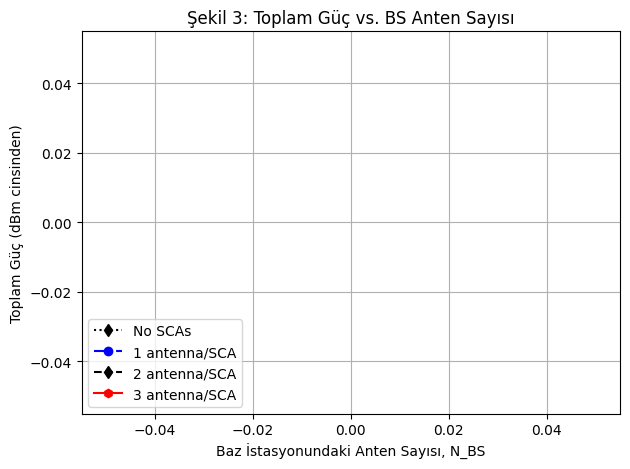

In [17]:
totalpower_average_fig3 = np.mean(total_power, axis=2)

totalpower_average_dBm = 10 * np.log10(totalpower_average_fig3)
plt.figure()
markers = ['kd:', 'bo-.', 'kd--', 'rh-']
labels = ['No SCAs', '1 antenna/SCA', '2 antenna/SCA', '3 antenna/SCA']

for i, label in enumerate(labels):
    plt.plot(NBS_cases, totalpower_average_dBm[:, i], markers[i], label=label)

plt.xlabel("Baz İstasyonundaki Anten Sayısı, N_BS")
plt.ylabel("Toplam Güç (dBm cinsinden)")
plt.legend(loc="lower left")
plt.grid(True)
plt.title("Şekil 3: Toplam Güç vs. BS Anten Sayısı")
plt.tight_layout()
plt.show()

In [18]:
from scipy.io import savemat

# Verileri hem .npz hem .mat formatında kaydet
np.savez("simulasyon_sonuclari.npz",
         total_power=total_power,
         optimal_user_allocation=optimal_user_allocation,
         NBS_cases=NBS_cases,
         NSCA_cases=NSCA_cases,
         nbr_of_realizations=nbr_of_realizations,
         Kt=Kt,
         Kr=Kr)

savemat("simulasyon_sonuclari.mat", {
    "total_power": total_power,
    "optimal_user_allocation": optimal_user_allocation,
    "NBS_cases": NBS_cases,
    "NSCA_cases": NSCA_cases,
    "nbr_of_realizations": nbr_of_realizations,
    "Kt": Kt,
    "Kr": Kr
})


## 🎯 Amaç: Figure 4 - Farklı Beamforming Şemalarıyla Güç Tüketimi Karşılaştırması

Şekil 4'te, farklı kullanıcı başına QoS hedeflerine (bits/s/Hz) karşılık üç farklı beamforming algoritmasının enerji tüketimi kıyaslanır:

1. **Sadece Makro Baz İstasyonu (BS)**: Tüm kullanıcılar tek BS tarafından servis edilir.
2. **Multiflow-RZF**: Her kullanıcıya birden fazla vericiden sinyal gönderilir (düşük karmaşıklıklı).
3. **Optimal Soft-Cell Koordinasyon**: QoS kısıtlarını karşılayan minimum güç optimizasyonu yapılır.

Her QoS değeri için 100 farklı kanal gerçekleşimi üzerinden ortalama alınarak karşılaştırma yapılır.